# 4 Practical Exercises and Real-Time Data Connection

In [ ]:
!pip install websockets
!pip install nest_asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 1.2 MB/s eta 0:00:00


In [1]:
# Import libraries
import asyncio
import websockets
import time
import json
import plotly.graph_objects as go
import plotly.express as px
import nest_asyncio
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from datetime import datetime, timedelta

In this notebook, we will apply what we have learned so far.

We will collect real-time data, specifically cryptocurrency data, because it is highly volatile. This volatility allows us to visualize changes at a much faster pace.

## Real-time Data Connection

First, we are going to connect to an internet-based service using a WebSocket.

Using `async` is recommended for WebSocket connections because it allows you to handle the asynchronous nature of WebSockets more efficiently.

### Asynchronous Code

- Uses `async` and `await` keywords to allow certain operations to run in the background.
- `async` marks a function as asynchronous, allowing it to perform non-blocking operations.
- `await` pauses the execution of an async function until the awaited task is complete, without blocking the entire program.

We also need `nest_asyncio`:

`nest_asyncio` is a Python library that allows you to nest multiple asynchronous event loops. Normally, Python’s `asyncio` library does not allow an event loop to be nested within another running event loop. This restriction can be problematic in interactive environments such as Jupyter Notebooks, where an event loop might already be running.


In [2]:
# nest_asyncioを適用してネストされたイベントループを許可する
nest_asyncio.apply()

# BTC/USDTのティッカー情報を取得するためのBinance WebSocket接続URI
uri = "wss://fstream.binance.com:443/ws/btcusdt@ticker"

# データを取得する間隔（秒単位）を定義する
interval = 1

# データを何回取得するかを定義する
times = 5

# 暗号通貨のデータを取得する非同期関数を定義する
async def get_crypto_data(uri, interval, times):
    # WebSocketへの接続を確立する
    async with websockets.connect(uri) as websocket:
        for k in range(times):
            # WebSocketからデータを受信する
            data = await websocket.recv()
            # 受信したデータをJSONオブジェクトとして解析する
            data_json = json.loads(data)
            # 解析したデータを出力する
            print(data_json)
            # 次のデータ取得まで指定された間隔だけ待機する
            await asyncio.sleep(interval)

# Run the async function to fetch data
asyncio.run(get_crypto_data(uri, interval, times))

As we can see, we get the data from Binance.

* `e`: Event type (24hrTicker)
* `E`: Event time
* `s`: Symbol
* `p`: Price change
* `P`: Price change percent
* `w`: Weighted average price
* `x`: First trade (previous day's close price)
* `c`: Last price
* `Q`: Last quantity
* `b`: Best bid price
* `B`: Best bid quantity
* `a`: Best ask price
* `A`: Best ask quantity
* `o`: Open price
* `h`: High price
* `l`: Low price
* `v`: Total traded base asset volume
* `q`: Total traded quote asset volume

But we would also like to know the time the data was collected. For this, we are going to use a `datetime` function.

## Explanation of the Data to be Saved and the Reason ##

In [7]:
datetime.now().strftime('%H:%M:%S')

'12:16:03'

In [8]:
# 暗号通貨データを取得する非同期関数を定義
async def get_crypto_data(uri, interval, times):
    # WebSocketへの接続を確立
    async with websockets.connect(uri) as websocket:
        for k in range(times):
            # WebSocketからデータを受信
            data = await websocket.recv()

            # 受信したデータをJSONオブジェクトとして解析
            data = json.loads(data)

            # 関連するフィールドを抽出
            price_change = float(data['P'])  # 価格変動率
            weighted_avg_price = float(data['w'])  # 加重平均価格
            last_quantity = float(data['Q'])  # 最後の取引量
            total_quote_volume = float(data['q'])  # 総取引量（引用資産）

            # 現在時刻を取得
            current_time = datetime.now().strftime('%H:%M:%S')

            # 抽出したデータと現在時刻を出力
            print(f"Change Pct: {price_change}, Price: {weighted_avg_price}, Last: {last_quantity}, Volume: {total_quote_volume}, Time: {current_time}")

            # 指定された間隔だけ待機してから次のデータを取得
            await asyncio.sleep(interval)

# 非同期関数を実行してデータを取得
asyncio.run(get_crypto_data(uri, interval, times))


Change Pct: 1.377, Price: 56567.72, Last: 0.078, Volume: 11844846956.45, Time: 12:17:30
Change Pct: 1.377, Price: 56567.72, Last: 0.006, Volume: 11844906391.25, Time: 12:17:32
Change Pct: 1.384, Price: 56567.73, Last: 0.048, Volume: 11845069613.14, Time: 12:17:34
Change Pct: 1.388, Price: 56567.74, Last: 0.01, Volume: 11845238131.96, Time: 12:17:36
Change Pct: 1.388, Price: 56567.74, Last: 0.002, Volume: 11845279918.23, Time: 12:17:38


Finally, we would like to make our function more versatile. Instead of running a fixed number of times, we want it to run for a specified period of time.


In [9]:
# データを1秒ごとに取得する間隔を定義
interval = 1  # 1秒ごとにデータを取得
# スクリプトの実行時間を分単位で定義
duration_minutes = 0.1  # 0.1分（6秒）間実行

# 暗号通貨データを取得する非同期関数を定義
async def get_crypto_data(uri, interval, duration_minutes):
    start_time = datetime.now()  # スクリプトの開始時刻を取得
    end_time = start_time + timedelta(minutes=duration_minutes)  # 終了時刻を計算
    async with websockets.connect(uri) as websocket:
        # forループをwhileループに変更して、現在時刻が終了時刻を過ぎるまで実行
        while datetime.now() < end_time:
            data = await websocket.recv()  # WebSocketからデータを受信
            data = json.loads(data)  # 受信したデータをJSONオブジェクトとして解析
            # 関連するフィールドを抽出
            price_change = float(data['P'])  # 価格変動率
            weighted_avg_price = float(data['w'])  # 加重平均価格
            last_quantity = float(data['Q'])  # 最後の取引量
            total_quote_volume = float(data['q'])  # 総取引量（引用資産）

            current_time = datetime.now().strftime('%H:%M:%S')  # 現在時刻を取得
            # 抽出したデータと現在時刻を出力
            print(f"Change Pct: {price_change}, Price: {weighted_avg_price}, Last: {last_quantity}, Volume: {total_quote_volume}, Time: {current_time}")
            await asyncio.sleep(interval)  # 指定された間隔だけ待機
    # スクリプトの開始時刻と終了時刻を出力
    print(f"Script started at: {start_time.strftime('%H:%M:%S')}, ended at: {end_time.strftime('%H:%M:%S')}")

# 非同期関数を実行してデータを取得
asyncio.run(get_crypto_data(uri, interval, duration_minutes))


Change Pct: 1.364, Price: 56567.9, Last: 0.002, Volume: 11847841653.74, Time: 12:17:56
Change Pct: 1.366, Price: 56567.9, Last: 0.015, Volume: 11847853287.16, Time: 12:17:58
Change Pct: 1.397, Price: 56567.96, Last: 0.005, Volume: 11831699108.28, Time: 12:18:00
Script started at: 12:17:55, ended at: 12:18:01


(This code sets the interval for fetching data every second and runs the function for 0.1 minutes (6 seconds). It fetches data from the WebSocket, extracts relevant fields, and prints them along with the current time.)

Now, imagine we want to plot the data that is being collected. We can't do it directly in Google Colab or a Jupyter notebook, as we would need to program a script solely to render such visuals dynamically.

The workaround for this is to plot and erase the plot each time new data arrives. Let's see how this works:

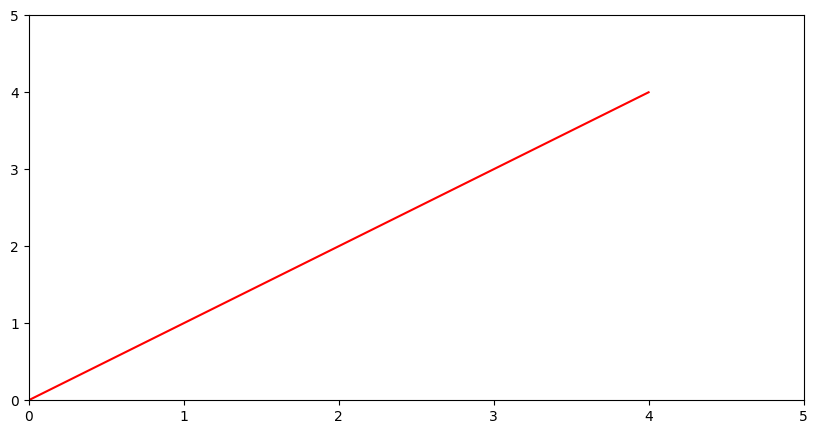

In [10]:
# 図と軸を作成
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([], [], 'r-')  # 線の初期化

# x軸とy軸の範囲を設定
ax.set_ylim(0, 5)
ax.set_xlim(0, 5)

# データリストの初期化
x_data = []
y_data = []

# 5回のループを実行
for k in range(5):
    x_data.append(datetime.now())  # 現在時刻をxデータに追加
    y_data.append(k)  # yデータにkを追加
    line.set_xdata(range(len(x_data)))  # xデータを更新
    line.set_ydata(y_data)  # yデータを更新
    ax.relim()  # 範囲を再計算
    ax.autoscale_view()  # 表示を自動スケール
    clear_output(wait=True)  # 出力をクリア
    display(fig)  # 図を表示
    time.sleep(1)  # 1秒待機

plt.close()  # 終了時にプロットを閉じる

Putting it all together, we can apply some minor changes, such as exception handling and dynamically adjusting axis sizes.

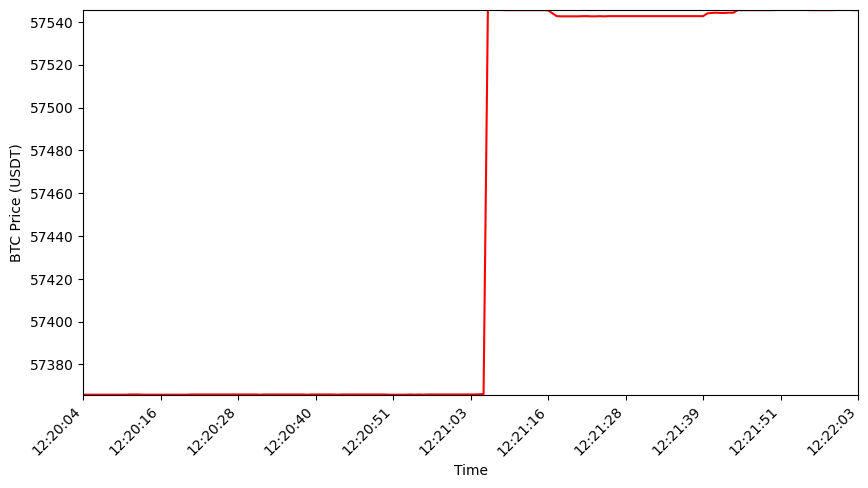

In [11]:
# BTC価格を動的に表示する関数を定義
async def fetch_data(interval, duration_minutes):
    nest_asyncio.apply()  # nest_asyncioを適用してネストされたイベントループを許可する
    # プロットを初期化
    fig, ax = plt.subplots(figsize=(10, 5))
    x_data = []
    y_data = []
    line, = ax.plot([], [], 'r-')  # 線の初期化
    ax.set_xlabel('Time')
    ax.set_ylabel('BTC Price (USDT)')
    display(fig)  # 初期図を表示

    # URI接続の設定
    uri = "wss://fstream.binance.com:443/ws/btcusdt@trade"
    start_time = datetime.now()  # 開始時刻を取得
    end_time = start_time + timedelta(minutes=duration_minutes)  # 終了時刻を定義

    # 終了時刻までループを実行
    while datetime.now() < end_time:
        try:
            async with websockets.connect(uri) as websocket:  # WebSocket接続を確立
                while datetime.now() < end_time:
                    response = await websocket.recv()  # WebSocketからデータを受信
                    data = json.loads(response)  # 受信したデータをJSONとして解析
                    trade_price = float(data['p'])  # 取引価格を浮動小数点数として抽出
                    current_time = datetime.now().strftime('%H:%M:%S')  # 現在時刻を取得（秒単位）

                    # プロットデータを更新
                    x_data.append(current_time)
                    y_data.append(trade_price)
                    line.set_xdata(range(len(x_data)))
                    line.set_ydata(y_data)

                    # y軸とx軸の範囲を動的に設定
                    ax.set_ylim(min(y_data) * 0.999999, max(y_data) * 1.000001)
                    ax.set_xlim(0, len(x_data) - 1)

                    # 比例的なx軸ラベルを10個表示
                    if len(x_data) > 1:
                        step = max(1, len(x_data) // 10)
                        ax.set_xticks(range(0, len(x_data), step))
                        ax.set_xticklabels([x_data[i] for i in range(0, len(x_data), step)], rotation=45, ha='right')

                    clear_output(wait=True)  # 出力をクリア
                    display(fig)  # 図を表示
                    await asyncio.sleep(interval)  # 指定された間隔でデータを取得
        except (websockets.exceptions.ConnectionClosedError, websockets.exceptions.ConnectionClosedOK):
            print("接続が閉じられました。再試行します...")
            await asyncio.sleep(interval)  # 再試行前に待機

    plt.close(fig)  # 最後の出力を抑制するために図を閉じる

# データ取得のパラメータ
interval = 0.5  # 0.5秒ごとにデータを取得
duration_minutes = 2  # 2分間実行

# 非同期関数を実行
asyncio.run(fetch_data(interval, duration_minutes))



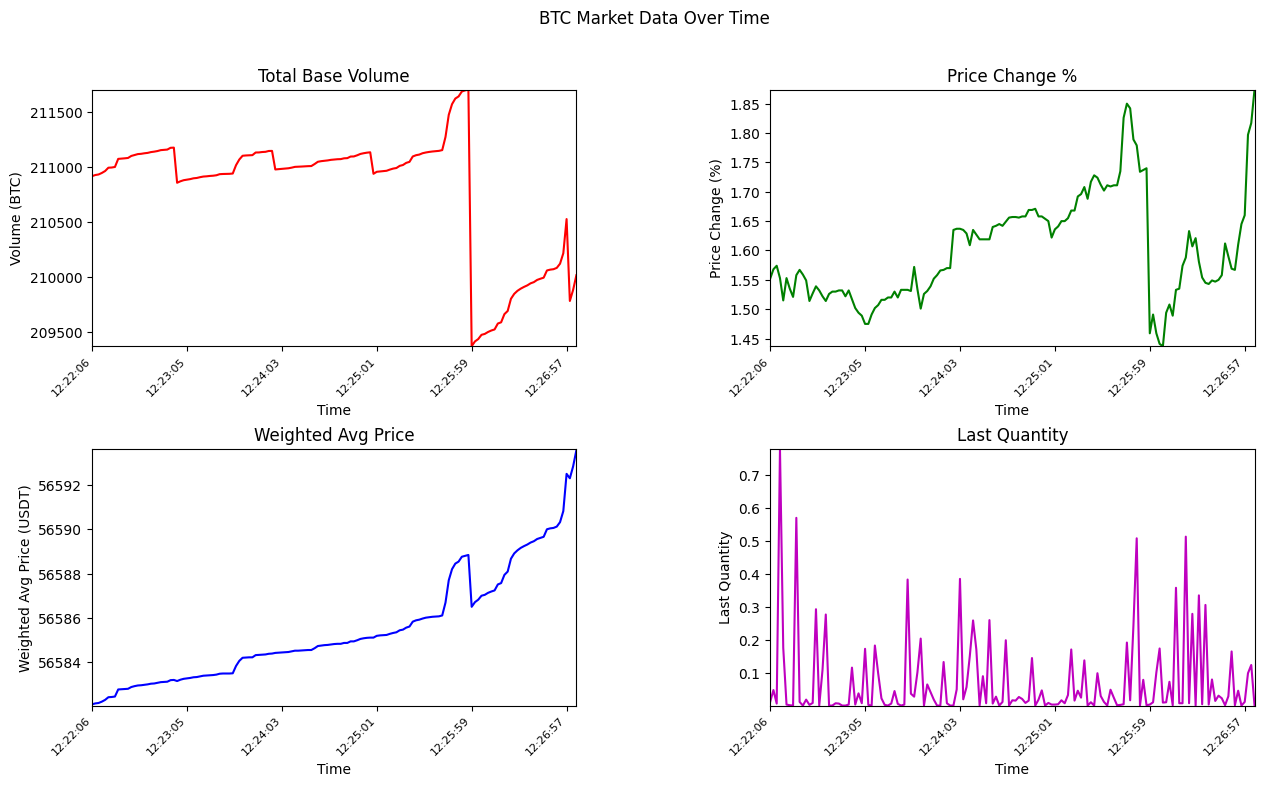

In [12]:
# 監視する暗号通貨のWebSocket URIを変更
uri = "wss://fstream.binance.com:443/ws/btcusdt@ticker"  # 監視する暗号通貨を変更
interval = 0.5  # データ取得間隔を変更
duration_minutes = 5  # 実行時間を希望する分数に変更

# より洗練されたプロットを作成する関数
async def fetch_data(uri, interval, duration_minutes):
    nest_asyncio.apply()  # nest_asyncioを適用してネストされたイベントループを許可する

    # 間隔を調整した2x2のプロットグリッドを初期化
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # サブプロット間の間隔を調整
    fig.suptitle('BTC Market Data Over Time')

    # データリストを初期化
    x_data = [[] for _ in range(4)]
    y_data = [[] for _ in range(4)]
    colors = ['r-', 'g-', 'b-', 'm-']  # 各サブプロットの色
    titles = ['Total Base Volume', 'Price Change %', 'Weighted Avg Price', 'Last Quantity']
    y_labels = ['Volume (BTC)', 'Price Change (%)', 'Weighted Avg Price (USDT)', 'Last Quantity']

    # 各サブプロットに線を作成
    lines = [ax.plot([], [], color)[0] for ax, color in zip(axs.flatten(), colors)]

    # 各サブプロットの設定
    for ax, title, y_label in zip(axs.flatten(), titles, y_labels):
        ax.set_xlabel('Time')
        ax.set_ylabel(y_label)
        ax.set_title(title)

    display(fig)  # 初期図を表示

    # URI接続の設定
    start_time = datetime.now()  # 開始時刻を取得
    end_time = start_time + timedelta(minutes=duration_minutes)  # 終了時刻を定義

    # 終了時刻までループを実行
    while datetime.now() < end_time:
        try:
            async with websockets.connect(uri) as websocket:  # WebSocket接続を確立
                while datetime.now() < end_time:
                    response = await websocket.recv()  # WebSocketからデータを受信
                    data = json.loads(response)

                    # 関連するフィールドを抽出
                    price_change = float(data['P'])  # 価格変動率を浮動小数点数として抽出
                    weighted_avg_price = float(data['w'])  # 加重平均価格を浮動小数点数として抽出
                    last_quantity = float(data['Q'])  # 最後の取引量を浮動小数点数として抽出
                    total_quote_volume = float(data['v'])  # 総取引量（基礎資産）を浮動小数点数として抽出

                    current_time = datetime.now().strftime('%H:%M:%S')  # 現在時刻を取得（秒単位）

                    # プロットデータを更新
                    x_data[0].append(current_time)
                    y_data[0].append(total_quote_volume)
                    x_data[1].append(current_time)
                    y_data[1].append(price_change)
                    x_data[2].append(current_time)
                    y_data[2].append(weighted_avg_price)
                    x_data[3].append(current_time)
                    y_data[3].append(last_quantity)

                    # 各サブプロットを更新
                    for i, ax in enumerate(axs.flatten()):
                        lines[i].set_xdata(range(len(x_data[i])))
                        lines[i].set_ydata(y_data[i])

                        # y軸とx軸の範囲を動的に設定
                        ax.set_ylim(min(y_data[i]) * 0.999999, max(y_data[i]) * 1.000001)
                        ax.set_xlim(0, len(x_data[i]) - 1)

                        # 比例的なx軸ラベル（最大5個）を小さいフォントサイズで表示
                        if len(x_data[i]) > 1:
                            step = max(1, len(x_data[i]) // 5)
                            ax.set_xticks(range(0, len(x_data[i]), step))
                            ax.set_xticklabels([x_data[i][j] for j in range(0, len(x_data[i]), step)], rotation=45, ha='right', fontsize=8)

                    clear_output(wait=True)  # 出力をクリア
                    display(fig)  # 図を表示
                    await asyncio.sleep(interval)  # 指定された間隔でデータを取得
        except (websockets.exceptions.ConnectionClosedError, websockets.exceptions.ConnectionClosedOK):
            print("接続が閉じられました。再試行します...")
            await asyncio.sleep(interval)  # 再試行前に待機

    # 最終出力を抑制
    plt.close(fig)
    return y_data, x_data

# 非同期関数を実行
y_data, x_data = asyncio.run(fetch_data(uri, interval, duration_minutes))
